## 필요한 패키지 및 기본 제공 함수 (Requirements)

In [9]:
!pip install PyKomoran
!pip install nltk
!pip install sklearn

In [10]:
# Data URLs
training_data_url = "https://drive.google.com/file/d/1UQZzMlBmSxAxFML7zZm1N3tc63pIfCOq/view?usp=share_link"
test_data_url = "https://drive.google.com/file/d/1UUK4-J-P8Bh5aJg0-VqaG9gDU7zRtF8j/view?usp=share_link"

# Download training data
training_data_file_id = training_data_url.split("/")[-2]
!gdown $training_data_file_id

# Download test data
test_data_file_id = test_data_url.split("/")[-2]
!gdown $test_data_file_id

Downloading...
From: https://drive.google.com/uc?id=1UQZzMlBmSxAxFML7zZm1N3tc63pIfCOq
To: /content/newsdata_train.json
100% 4.80M/4.80M [00:00<00:00, 256MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UUK4-J-P8Bh5aJg0-VqaG9gDU7zRtF8j
To: /content/newsdata_test.json
100% 1.17M/1.17M [00:00<00:00, 182MB/s]


In [11]:
# Import libraries
import nltk
nltk.download('punkt')

import json
import torch
from tqdm.notebook import trange, tqdm
from PyKomoran import *
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import random
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Provided functions

def load_data(path) :
  with open(path) as f :
    data = json.load(f)

  return data


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def tokenizer(sentences):
    sentence = []
    for s in sent_tokenize(sentences) :
        sentence += komoran.get_morphes_by_tags(s, tag_list=["NNG", "NNP", "VV"])

    return sentence

# TF-IDF와 MLP를 이용한 문서 분류

## PyKomoran 형태소 분석기

In [5]:
komoran = Komoran("EXP")

str_to_analyze = "자연어 처리는 인간의 언어 현상을 컴퓨터와 같은 기계를 이용해서 묘사할 수 있도록 연구하고\
 이를 구현하는 인공지능의 주요 분야 중 하나입니다."

# get_nouns(): 입력 문장에서 명사만 추출합니다.
print(komoran.get_nouns(str_to_analyze))

# get_morphes_by_tags(): 입력 문장에서 주어진 품사들만 추출합니다.
print(komoran.get_morphes_by_tags(str_to_analyze, tag_list=['NNP', 'NNG', 'SF']))

# get_plain_text(): 입력 문장 내에 형태소/품사 형태로 태그를 합니다.
print(komoran.get_plain_text(str_to_analyze))

['자연어', '처리', '인간', '언어', '현상', '컴퓨터', '기계', '이용', '묘사', '연구', '구현', '인공지능', '주요', '분야']
['자연어', '처리', '인간', '언어', '현상', '컴퓨터', '기계', '이용', '묘사', '연구', '구현', '인공지능', '주요', '분야', '.']
자연어/NNP 처리/NNG 는/JX 인간/NNG 의/JKG 언어/NNG 현상/NNG 을/JKO 컴퓨터/NNG 와/JC 같/VA 은/ETM 기계/NNG 를/JKO 이용/NNG 하/XSV 아서/EC 묘사/NNG 하/XSV ㄹ/ETM 수/NNB 있/VV 도록/EC 연구/NNG 하/XSV 고/EC 이/NP 를/JKO 구현/NNG 하/XSV 는/ETM 인공지능/NNP 의/JKG 주요/NNG 분야/NNG 중/NNB 하나/NR 이/VCP ㅂ니다/EF ./SF


In [12]:
#@title
print(komoran.get_token_list(str_to_analyze))
print(komoran.get_list(str_to_analyze))

[자연어/NNP(0,3), 처리/NNG(4,6), 는/JX(6,7), 인간/NNG(8,10), 의/JKG(10,11), 언어/NNG(12,14), 현상/NNG(15,17), 을/JKO(17,18), 컴퓨터/NNG(19,22), 와/JC(22,23), 같/VA(24,25), 은/ETM(25,26), 기계/NNG(27,29), 를/JKO(29,30), 이용/NNG(31,33), 하/XSV(33,35), 아서/EC(33,35), 묘사/NNG(36,38), 하/XSV(38,39), ㄹ/ETM(38,39), 수/NNB(40,41), 있/VV(42,43), 도록/EC(43,45), 연구/NNG(46,48), 하/XSV(48,49), 고/EC(49,50), 이/NP(51,52), 를/JKO(52,53), 구현/NNG(54,56), 하/XSV(56,57), 는/ETM(57,58), 인공지능/NNP(59,63), 의/JKG(63,64), 주요/NNG(65,67), 분야/NNG(68,70), 중/NNB(71,72), 하나/NR(73,75), 이/VCP(75,76), ㅂ니다/EF(75,78), ./SF(78,79)]
[자연어/NNP, 처리/NNG, 는/JX, 인간/NNG, 의/JKG, 언어/NNG, 현상/NNG, 을/JKO, 컴퓨터/NNG, 와/JC, 같/VA, 은/ETM, 기계/NNG, 를/JKO, 이용/NNG, 하/XSV, 아서/EC, 묘사/NNG, 하/XSV, ㄹ/ETM, 수/NNB, 있/VV, 도록/EC, 연구/NNG, 하/XSV, 고/EC, 이/NP, 를/JKO, 구현/NNG, 하/XSV, 는/ETM, 인공지능/NNP, 의/JKG, 주요/NNG, 분야/NNG, 중/NNB, 하나/NR, 이/VCP, ㅂ니다/EF, ./SF]


## 데이터 로드 및 전처리 (Preprocess)

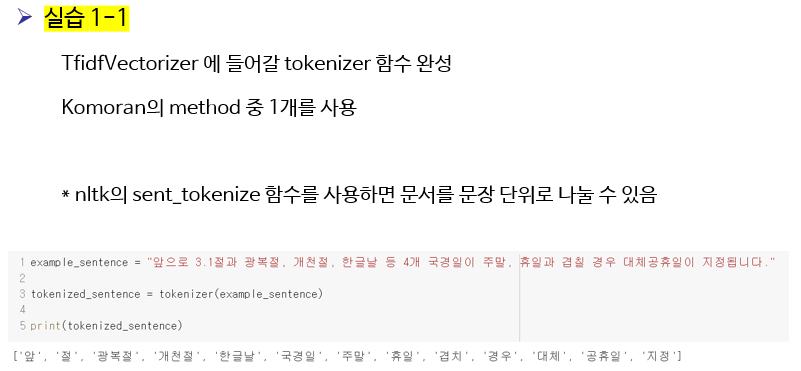

In [59]:
# 실습 1-1
# komoran 형태소 분석기를 활용하여 TfidfVectorizer에 들어갈 tokenizer 함수를 완성해주세요.
# sentences는 str type이지만 여러 문장으로 구성되어 있을 수 있습니다.
# nltk library의 sent_tokenize를 이용하면 여러 문장으로 된 하나의 str 변수를 문장 단위로 나눌 수 있습니다.
# input : sentences (type : List)
# output : sentence (type : List)

def tokenizer(sentences: list) -> list:

    # 이곳에 코드를 작성해주세요 #
    sentence = []
    for s in sent_tokenize(sentences):
      # print("s:")
      # print(s)
      tokenized = komoran.get_plain_text(s)
      # print("tokenized:")
      # print(tokenized)
      for tok in tokenized.split(" "):
        if tok == "": continue
        try:
          if tok.split("/")[1] in ["NNG", "NNP", "VV"] : continue
        except:
          # print("error:!!!!!!!!!!!!!!")
          # print(tok)
          pass
        finally:
          pass
        sentence.append(tok)

    # ------------------------- #

    return sentence

In [56]:
example_sentence = "앞으로 3.1절과 광복절, 개천절, 한글날 등 4개 국경일이 주말, 휴일과 겹칠 경우 대체공휴일이 지정됩니다."

tokenized_sentence = tokenizer(example_sentence)

print("tokenized_sentence:")
print(tokenized_sentence)

tokenized_sentence:
['으로/JKB', '3/SN', './SF', '1/SN', '과/JC', ',/SP', ',/SP', '등/NNB', '4/SN', '개/NNB', '이/JKS', ',/SP', '과/JC', 'ㄹ/ETM', '이/JKS', '되/XSV', 'ㅂ니다/EF', './SF']


In [26]:
s = "가나다라. 마바사"
sent_tokenize(s)

['가나다라.', '마바사']

In [13]:
train_path = "./newsdata_train.json"
test_path = "./newsdata_test.json"
label_list = ['IT', '경제', '문화', '스포츠', '정치']

train_data = load_data(train_path)
test_data = load_data(test_path)

komoran = Komoran("EXP")

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenizer
)

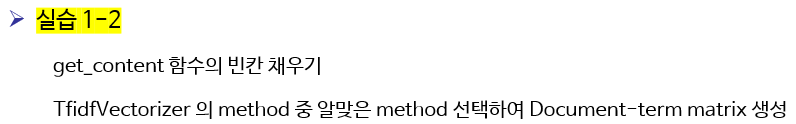

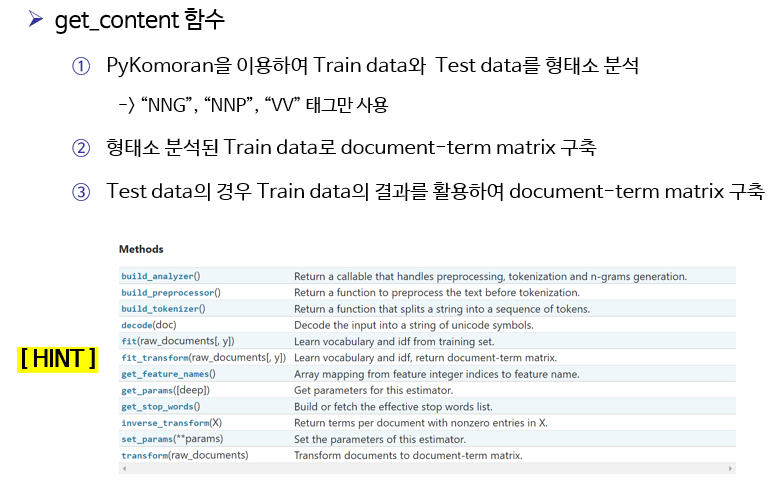

In [54]:
# 실습 1-2
# TfidfVectorizer의 method 중 1개를 선택하여 document-term matrix를 생성하는 코드를 작성해주세요.
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# input : doc_list (type : List)
# output : X (type : sparse matrix)

def get_content(data, tfidf_vectorizer, mode="train") :

    doc_list = []
    for d in data:
        doc_list.append(d["content"])


    if mode == "train" :

        # 이곳에 코드를 작성해주세요 #
        X = tfidf_vectorizer.fit_transform(doc_list)
        # ------------------------- #

        print(
            'Document-term matrix from train set : (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
        )

    elif mode == "test" :

        # 이곳에 코드를 작성해주세요 #
        X = tfidf_vectorizer.transform(doc_list)
        # ------------------------- #

        print(
            'Document-term matrix from test set : (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
        )

    content_tensors = torch.tensor(X.toarray(), dtype=torch.float32)

    return content_tensors


def get_label(data, label_list) :

    labels2idx = {label: i for i, label in enumerate(label_list)}

    labels = list()

    for doc in data:
        labels.append(labels2idx[doc["topic"]])

    label_tensors = torch.tensor(labels, dtype=torch.long)

    return label_tensors


def make_dataset(content_tensor, label_tensor) :
    return torch.utils.data.TensorDataset(content_tensor, label_tensor)

In [58]:
train_input = get_content(train_data, tfidf_vectorizer)
train_output = get_label(train_data, label_list)

train_dataset = make_dataset(train_input, train_output)

test_input = get_content(test_data, tfidf_vectorizer, mode="test")
test_output = get_label(test_data, label_list)

test_dataset = make_dataset(test_input, test_output)

error:!!!!!!!!!!!!!!
아베
error:!!!!!!!!!!!!!!
2006년
error:!!!!!!!!!!!!!!
2007년
error:!!!!!!!!!!!!!!
법무법인
error:!!!!!!!!!!!!!!
정지궤도
error:!!!!!!!!!!!!!!
젊음의
error:!!!!!!!!!!!!!!
이
error:!!!!!!!!!!!!!!
7월
error:!!!!!!!!!!!!!!
허비
error:!!!!!!!!!!!!!!
오즈의
error:!!!!!!!!!!!!!!
존
error:!!!!!!!!!!!!!!
노무현
error:!!!!!!!!!!!!!!
한국은행
error:!!!!!!!!!!!!!!
8월
error:!!!!!!!!!!!!!!
그럼에도
error:!!!!!!!!!!!!!!
비교
error:!!!!!!!!!!!!!!
1월
error:!!!!!!!!!!!!!!
필라델피아
error:!!!!!!!!!!!!!!
콜로라도
error:!!!!!!!!!!!!!!
트로이
error:!!!!!!!!!!!!!!
체이스
error:!!!!!!!!!!!!!!
2007년
error:!!!!!!!!!!!!!!
2월
error:!!!!!!!!!!!!!!
올림픽
error:!!!!!!!!!!!!!!
올림픽
error:!!!!!!!!!!!!!!
고다이라
error:!!!!!!!!!!!!!!
2014년
error:!!!!!!!!!!!!!!
위대한
error:!!!!!!!!!!!!!!
위대한
error:!!!!!!!!!!!!!!
이명박
error:!!!!!!!!!!!!!!
사회
error:!!!!!!!!!!!!!!
이명박
error:!!!!!!!!!!!!!!
사생활
error:!!!!!!!!!!!!!!
독점규제
error:!!!!!!!!!!!!!!
및
error:!!!!!!!!!!!!!!
공정거래에
error:!!!!!!!!!!!!!!
관한
error:!!!!!!!!!!!!!!
하도급거래
error:!!!!!!!!!!!!!!
공정화에
error:!!!!!!!!!!!!

## 모델 학습 (Train)

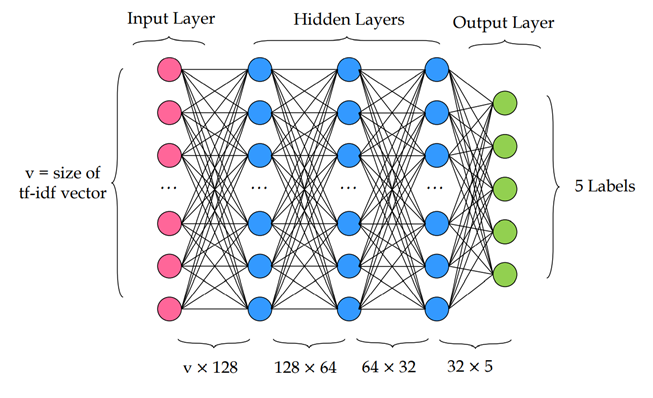

In [61]:
input_data = torch.randn(2, 3) # (input_dim, hidden_size)

input_data

tensor([[ 0.4007,  0.3379, -1.2575],
        [ 1.4599,  0.8409,  1.7302]])

In [62]:
m = torch.nn.Linear(3, 5) # (hidden_size, output_dim)

output = m(input_data)

print("*** Before ReLU Activation function ***\n")
print(output)

output = torch.nn.functional.relu(output)

print("\n*** After ReLU Activation function ***\n")
print(output)

print(output.size) # (input_dim, output_dim)

*** Before ReLU Activation function ***

tensor([[-0.1812,  0.2215, -0.4431,  0.8358, -1.3302],
        [-0.9202, -2.1019,  1.6435, -0.8141, -0.0317]],
       grad_fn=<AddmmBackward0>)

*** After ReLU Activation function ***

tensor([[0.0000, 0.2215, 0.0000, 0.8358, 0.0000],
        [0.0000, 0.0000, 1.6435, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
<built-in method size of Tensor object at 0x7feb77ba2160>


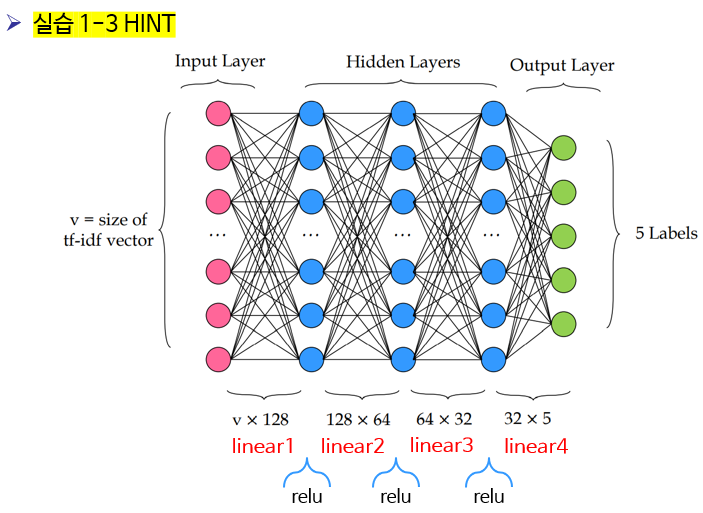

In [81]:
# 실습 1-3
# torch.nn.Linear(input, output) 함수를 사용하여 모델을 구현해주세요
# 모델 각 레이어 가중치의 크기는 위 그림을 따라 설정해주세요

class MLP(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()

        # 이곳에 코드를 작성해주세요 #
        self.linear1 = torch.nn.Linear(input_dim, 128)
        self.linear2 = torch.nn.Linear(128, 64)
        self.linear3 = torch.nn.Linear(64, 32)
        self.linear4 = torch.nn.Linear(32, output_dim)
        # self.linear1 = torch.nn.Linear(input_dim, 1024)
        # self.linear2 = torch.nn.Linear(1024, 512)
        # self.linear3 = torch.nn.Linear(512, 64)
        # self.linear4 =torch.nn.Linear(64, 5)

        # ------------------------- #


    def forward(self, inputs): #
        # 이곳에 코드를 작성해주세요 #
        # y1 = torch.nn.functional.relu(self.linear1(inputs)) #24477
        # y2 = torch.nn.functional.relu(self.linear1(y1))
        # y3 = torch.nn.functional.relu(self.linear1(y2))
        y1 = self.linear1(inputs)
        # y1 = torch.nn.functional.relu(y1)
        y2 = self.linear2(y1)
        y3 = self.linear3(y2)

        # ------------------------- #

        # return torch.sigmoid(self.linear4(y3))
        return self.linear4(y3)

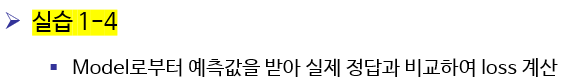

In [82]:
# 실습 1-4
# model로부터 예측값을 받아오고,
# 예측값과 정답 간의 loss를 계산하는 코드를 작성해주세요.
# loss 함수로는 crossentropy loss 함수를 사용합니다. (criterion에 정의되어 있음)
# loss function에 입력되는 예측값(prediction)과 실제 정답(label)의 shape에 유의할 것!

def train(model, train_dataset, args):

    set_seed(42)

    train_batch_size = args["train_batch_size"]
    num_train_epochs = args["num_train_epochs"]
    device = args["device"]
    learning_rate = args["learning_rate"]

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function
    criterion = torch.nn.CrossEntropyLoss()

    train_dataLoader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

    train_iterator = trange(num_train_epochs, desc="Epoch")

    print("\n***** Running training *****")
    print("  Num examples = {}".format(len(train_dataset)))
    print("  Num Epochs = {}".format(num_train_epochs))
    print("  Train Batch size = {}".format(train_batch_size))
    print("  Device = ", device)

    model.to(device)
    model.train(True)
    model.zero_grad()
    for epoch in train_iterator:
        loss = 0
        for batch in train_dataLoader:
            input_vector = batch[0].to(device)
            label = batch[1].to(device)

            # 이곳에 코드를 작성해주세요 #
            predict = model(input_vector)
            loss =  criterion(predict, label)
            # ------------------------- #
            loss += loss.item()

            loss.backward()
            optimizer.step()
            model.zero_grad()

        if (epoch + 1) % 100 == 0:
            print("\n********** Train Result **********")
            print("  Epoch / Total Epoch : {} / {}".format(epoch + 1, num_train_epochs))
            print("  Loss : {:.4f}".format(loss))

    model.train(False)
# end of train

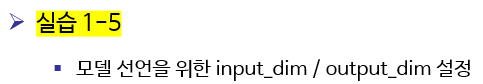

In [83]:
# 실습 1-5
# model 선언을 위한 input_dim과 output_dim 을 설정해주세요

input_dim = train_input.shape[-1]  # 이곳에 코드를 작성해주세요 #
output_dim = len(label_list) # 이곳에 코드를 작성해주세요 #


model = MLP(input_dim, output_dim)


args = dict()
args["train_batch_size"] = 64
args["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args["learning_rate"] = 0.001
args["num_train_epochs"] = 1000

train(model, train_dataset, args)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]


***** Running training *****
  Num examples = 800
  Num Epochs = 1000
  Train Batch size = 64
  Device =  cuda

********** Train Result **********
  Epoch / Total Epoch : 100 / 1000
  Loss : 0.0001

********** Train Result **********
  Epoch / Total Epoch : 200 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 300 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 400 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 500 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 600 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 700 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 800 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 900 / 1000
  Loss : 0.0000

********** Train Result **********
  Epoch / Total Epoch : 1000 / 1000
  Loss : 0.0000


## 모델 학습 후 평가 (Evaluation)

In [5]:
def evaluate(model, test_dataset, args, news_num=150):
    test_dataLoader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

    device = args["device"]

    print("***** Running evaluation *****")
    print("  Num examples = {}".format(len(test_dataset)))
    print("  Test Batch size = 1")

    model.eval()
    pred = None
    label = None
    for batch in test_dataLoader:
        input_vector = batch[0].to(device)

        with torch.no_grad():
            predict = model(input_vector)

        if pred is None:
            pred = predict.detach().cpu().numpy()
            label = batch[1].numpy()
        else:
            pred = np.append(pred, predict.detach().cpu().numpy(), axis=0)
            label = np.append(label, batch[1].numpy(), axis=0)

    pred = np.argmax(pred, axis=1)

    sample_pred1 = pred[news_num]
    sample_label1 = label[news_num]
    sample_result1 = {"pred": sample_pred1, "label": sample_label1}

    news_num -= 50
    sample_pred2 = pred[news_num]
    sample_label2 = label[news_num]
    sample_result2 = {"pred": sample_pred2, "label": sample_label2}

    accuracy = (pred == label).sum() / 200

    return accuracy, sample_result1, sample_result2

In [4]:
accuracy, sample_result1, sample_result2 = evaluate(model, test_dataset, args, news_num=99)

print("\n********** Total Test Result **********")
print("  Accuracy {}".format(accuracy))
print("\n********** Sample Result **********")
print("  Sample 1 pred : {} ({})".format(sample_result1["pred"], label_list[sample_result1["pred"]]))
print("  Sample 1 label : {} ({})".format(sample_result1["label"], label_list[sample_result1["label"]]))
print("  Sample 1 : {}".format(test_data[99]))
print("\n********** Sample Result **********")
print("  Sample 2 pred : {} ({})".format(sample_result2["pred"], label_list[sample_result2["pred"]]))
print("  Sample 2 label : {} ({})".format(sample_result2["label"], label_list[sample_result2["label"]]))
print("  Sample 2 : {}".format(test_data[49]))

NameError: ignored

## 전체 실행 코드

In [6]:
# main

train_path = "./newsdata_train.json"
test_path = "./newsdata_test.json"
label_list = ['IT', '경제', '문화', '스포츠', '정치']

train_data = load_data(train_path)
test_data = load_data(test_path)

args = dict()
args["train_batch_size"] = 64
args["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args["learning_rate"] = 0.001
args["num_train_epochs"] = 1000

komoran = Komoran("EXP")

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_input = get_content(train_data, tfidf_vectorizer)
train_output = get_label(train_data, label_list)

train_dataset = make_dataset(train_input, train_output)

test_input = get_content(test_data, tfidf_vectorizer, mode="test")
test_output = get_label(test_data, label_list)

test_dataset = make_dataset(test_input, test_output)

input_dim = train_input.shape[-1]
output_dim = len(label_list)

model = MLP(input_dim, output_dim)

train(model, train_dataset, args)

accuracy, sample_result = evaluate(model, test_dataset, args, news_num=900)

print("\n********** Total Test Result **********")
print("  Accuracy {}".format(accuracy))
print("  Sample pred : {}".format(sample_result["pred"]))
print("  Sample label : {}".format(sample_result["label"]))

NameError: ignored

# Word embedding과 CNN을 이용한 문서 분류

## 데이터 로드 및 전처리 (Preprocess)



1.   PyKomoran을 이용하여 train data와 test data를 형태소 분석 (품사 종류와 상관없이 모든 형태소를 이용함)
2.   형태소 분석한 train data를 이용하여 word2idx 구축
3.   train data의 label들을 이용하여 label2idx 구축
4.   word2idx와 label2idx를 이용하여 train data와 test data의 word와 label들을 index로 변환

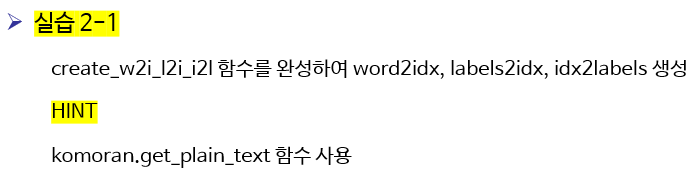

In [16]:
# 실습 2-1
# word2idx, labels2idx, idx2labels 를 반환하는 함수를 완성해주세요.

def create_w2i_l2i_i2l(data, label_list, komoran) :

    # 이곳에 코드를 작성해주세요 #
    word2idx = {
        '<PAD>': 0,
        '<UNK>': 1,
    }

    pos_tagged_text = set()
    for d in data:
      for s in sent_tokenize(d['content']):
          pos_tagged_text.update(komoran.get_plain_text(s).split(" "))

    for idx, token in enumerate(sorted(pos_tagged_text)):
        word2idx[token] = idx + 2


    labels2idx = {label: i for i, label in enumerate(label_list)}
    idx2labels = {i: label for i, label in enumerate(label_list)}

    # ------------------------- #

    return word2idx, labels2idx, idx2labels, pos_tagged_text

In [17]:
word2idx, labels2idx, idx2labels, pos_tagged_text = create_w2i_l2i_i2l(train_data, label_list, komoran)

In [18]:
def convert_examples_to_features(data, word2idx, labels2idx, komoran, max_length=512):
    input_ids = list()
    labels = list()

    for doc in tqdm(data):
        doc_ids = []
        sentences = sent_tokenize(doc["content"])
        for sentence in sentences:
            doc_ids.extend(
                [
                    word2idx[w if w in word2idx else '<UNK>']
                    for w in komoran.get_plain_text(sentence).split(' ')
                ]
            )

        if len(doc_ids) < max_length:
            doc_ids += [word2idx['<PAD>']] * (max_length - len(doc_ids))

        elif len(doc_ids) > max_length:
            doc_ids = doc_ids[:max_length]

        input_ids.append(doc_ids)
        labels.append(labels2idx[doc["topic"]])

    return input_ids, labels


def make_dataset(input_ids, labels):
    return torch.utils.data.TensorDataset(torch.tensor(input_ids, dtype=torch.long),
                                          torch.tensor(labels, dtype=torch.long))

In [108]:
komoran = Komoran("EXP")


ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43927)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 982, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1120, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored

In [19]:
train_inputs, train_labels = convert_examples_to_features(train_data, word2idx, labels2idx, komoran, max_length=512)
train_dataset = make_dataset(train_inputs, train_labels)

test_inputs, test_labels = convert_examples_to_features(test_data, word2idx, labels2idx, komoran, max_length=512)
test_dataset = make_dataset(test_inputs, test_labels)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

## 모델 정의

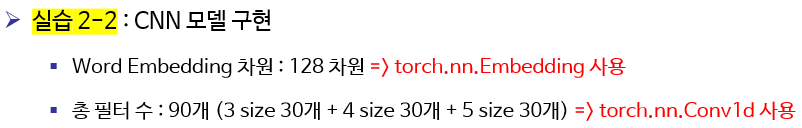

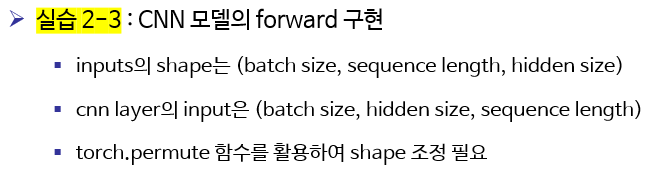

In [20]:
# 실습 2-2 & 2-3
# torch.nn.Embedding 함수와 torch.nn.Conv1d 함수를 사용하여 모델을 구현해주세요

class CNN(torch.nn.Module):
    def __init__(self, vocab_size, output_dim):
        super(CNN, self).__init__()

        INPUT_DIM = 128
        # 이곳에 코드를 작성해주세요 #
        self.word_embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=INPUT_DIM,)
        self.conv_layer1 = torch.nn.Conv1d(INPUT_DIM, 30, 3) # 3 size 30 개
        self.conv_layer2 = torch.nn.Conv1d(INPUT_DIM, 30, 4)
        self.conv_layer3 = torch.nn.Conv1d(INPUT_DIM, 30, 5)
        # ------------------------- #

        self.dropout = torch.nn.Dropout(0.1)
        self.fc = torch.nn.Linear(3 * 30, output_dim, bias=True)

    def forward(self, inputs):
        # input shape: (8, doc_length)

        # 이곳에 코드를 작성해주세요 #
        embedded = self.word_embed(inputs) # (B, L, C_in)

        conv1 = self.conv_layer1(embedded.permute(0, 2, 1)).permute(0, 2, 1).max(1)[0]
        conv2 = self.conv_layer2(embedded.permute(0, 2, 1)).permute(0, 2, 1).max(1)[0]
        conv3 = self.conv_layer3(embedded.permute(0, 2, 1)).permute(0, 2, 1).max(1)[0] # (max_value, max_index)

        conv1 = torch.nn.functional.relu(conv1)
        conv2 = torch.nn.functional.relu(conv2)
        conv3 = torch.nn.functional.relu(conv3)
        # ------------------------- #

        x = torch.cat([conv1, conv2, conv3], dim=1)

        output = self.fc(self.dropout(x))

        return output

## 학습 함수

In [ ]:
def train(model, train_dataset, args):

    set_seed(42)

    train_batch_size = args["train_batch_size"]
    num_train_epochs = args["num_train_epochs"]
    device = args["device"]
    learning_rate = args["learning_rate"]

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function
    criterion = torch.nn.CrossEntropyLoss()

    train_dataLoader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

    train_iterator = trange(num_train_epochs, desc="Epoch")

    print("\n***** Running training *****")
    print("  Num examples = {}".format(len(train_dataset)))
    print("  Num Epochs = {}".format(num_train_epochs))
    print("  Train Batch size = {}".format(train_batch_size))
    print("  Device = ", device)

    model.to(device)
    model.train(True)
    model.zero_grad()
    for epoch in train_iterator:
        loss = 0
        for batch in train_dataLoader:
            input_vector = batch[0].to(device)
            label = batch[1].to(device)
            predict = model(input_vector)

            loss = criterion(predict, label)
            loss += loss.item()

            loss.backward()
            optimizer.step()
            model.zero_grad()

        if (epoch + 1) % 100 == 0:
            print("\n********** Train Result **********")
            print("  Epoch / Total Epoch : {} / {}".format(epoch + 1, num_train_epochs))
            print("  Loss : {:.4f}".format(loss))

    model.train(False)
# end of train

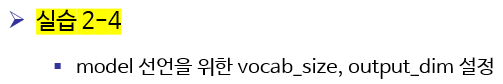

In [ ]:
# 실습 2-4
# model 선언을 위한 input_dim과 output_dim 을 설정해주세요

vocab_size = # 이곳에 코드를 작성해주세요 #
output_dim = # 이곳에 코드를 작성해주세요 #


args = dict()
args["train_batch_size"] = 64
args["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args["learning_rate"] = 0.0005
args["num_train_epochs"] = 500

model = CNN(vocab_size, output_dim)

train(model, train_dataset, args)

In [ ]:
def evaluate(model, test_dataset, args, news_num=900):
    test_dataLoader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

    device = args["device"]

    print("***** Running evaluation *****")
    print("  Num examples = {}".format(len(test_dataset)))
    print("  Test Batch size = 1")

    model.eval()
    pred = None
    label = None
    for batch in test_dataLoader:
        input_vector = batch[0].to(device)

        with torch.no_grad():
            predict = model(input_vector)

        if pred is None:
            pred = predict.detach().cpu().numpy()
            label = batch[1].numpy()
        else:
            pred = np.append(pred, predict.detach().cpu().numpy(), axis=0)
            label = np.append(label, batch[1].numpy(), axis=0)

    pred = np.argmax(pred, axis=1)

    sample_pred1 = pred[news_num]
    sample_label1 = label[news_num]
    sample_result1 = {"pred": sample_pred1, "label": sample_label1}

    news_num -= 50
    sample_pred2 = pred[news_num]
    sample_label2 = label[news_num]
    sample_result2 = {"pred": sample_pred2, "label": sample_label2}

    accuracy = (pred == label).sum() / 200

    return accuracy, sample_result1, sample_result2

In [ ]:
accuracy, sample_result1, sample_result2 = evaluate(model, test_dataset, args, news_num=199)

print("\n********** Total Test Result **********")
print("  Accuracy {}".format(accuracy))
print("\n********** Sample Result **********")
print("  Sample 1 pred : {} ({})".format(sample_result1["pred"], label_list[1]))
print("  Sample 1 label : {} ({})".format(sample_result1["label"], label_list[1]))
print("  Sample 1 : {}".format(test_data[199]))
print("\n********** Sample Result **********")
print("  Sample 2 pred : {} ({})".format(sample_result2["pred"], label_list[1]))
print("  Sample 2 label : {} ({})".format(sample_result2["label"], label_list[4]))
print("  Sample 1 : {}".format(test_data[149]))

## 전체 실행 코드

In [ ]:
# main

train_path = "./newsdata_train.json"
test_path = "./newsdata_test.json"
label_list = ['IT', '경제', '문화', '스포츠', '정치']

train_data = load_data(train_path)
test_data = load_data(test_path)

komoran = Komoran("EXP")

args = dict()
args["train_batch_size"] = 64
args["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args["learning_rate"] = 0.0005
args["num_train_epochs"] = 500

word2idx, labels2idx, idx2labels = create_w2i_l2i_i2l(train_data, label_list, komoran)

train_inputs, train_labels = convert_examples_to_features(train_data, word2idx, labels2idx, komoran, max_length=512)
train_dataset = make_dataset(train_inputs, train_labels)

test_inputs, test_labels = convert_examples_to_features(test_data, word2idx, labels2idx, komoran, max_length=512)
test_dataset = make_dataset(test_inputs, test_labels)

input_dim = len(word2idx)
output_dim = len(label_list)

model = CNN(input_dim, output_dim)

train(model, train_dataset, args)

accuracy, sample_result = evaluate(model, test_dataset, args, news_num=900)

print("\n********** Total Test Result **********")
print("  Accuracy {}".format(accuracy))
print("  Sample pred : {}".format(sample_result["pred"]))
print("  Sample label : {}".format(sample_result["label"]))